In [1]:
!pip install pandarallel python-chess numpy

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from pandarallel import pandarallel
from multiprocessing import  Pool
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import chess

random.seed(420)
np.random.seed(420)

In [3]:
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [4]:
df = pd.read_csv("chessData.csv")

Generate computed features of
* Pieces on the board
* Evaluation in pawns
* Material advantage using accepted valuations of pieces
* Cutoff material advantage - material advantage capped to 2 pawns
* Win Lose Draw - put position into categories:
  0. Black is absurdly winning
  1. Black is convincingly winning
  2. Drawish
  3. White is convincingly winning
  4. White is absurdly winning
* Normalized Evaluation - arctan(evaluation in pawns / 3)
* Normalized WLD - divide into three groups stratified by normalized evaluation
  
Using material advantages however may be misleading since if a piece was just taken, the material advantage found by counting pieces and their values will yield a result that could be anywhere from 1 to 9 pawns off. This can introduce a lot of noise and detracts away from those positions where there truly is a material advantage.

In [5]:
values = {
    "P": 1,
    "R": 5,
    "B": 3,
    "N": 3,
    "K": 0, # 0 since both sides have one king
    "Q": 9
}
for k, v in list(values.items()):
    values[k.lower()] = -v

def material_advantage(fen, pat=re.compile(r"[a-zA-Z]"), val=values):
    return sum(map(val.get, re.findall(pat, fen.split(' ')[0])))

def material_advantage_with_cutoff(fen):
    return min(2, max(-2, material_advantage(fen)))

def clamp(bot, top):
    return lambda num: min(top, max(bot, num))

def win_lose_draw(evaluation):
    if evaluation < -10:
        return 0
    if evaluation < -1.5:
        return 1
    if evaluation < 1.5:
        return 2
    if evaluation < 10:
        return 3
    return 4

def tan_eval_categories(evaluation):
    if evaluation < -.5:
        return 0
    if evaluation > .5:
        return 1
    return 2

def eval_to_int(evaluation):
    try:
        res = int(evaluation)
    except ValueError:
        res = 10000 if evaluation[1] == '+' else -10000
    return res / 100

count_pieces = lambda fen, pat=re.compile(r"[a-zA-Z]"): len(re.findall(pat, fen.split(' ')[0]))
transform_eval = lambda x: np.arctan(x / 3)
untransform_eval = lambda x: 3 * np.tan(x)

In [11]:
from pandarallel import pandarallel
import re

pandarallel.initialize()

# Don't generate unneeded fields to speed up execution
df["Pieces"] = df["FEN"].parallel_map(count_pieces)
df["Evaluation"] = df["Evaluation"].parallel_map(eval_to_int)
df["Normalized Evaluation"] = transform_eval(df["Evaluation"])
# df["Material advantage"] = df["FEN"].parallel_map(material_advantage)
# df["Cutoff Material advantage"] = df["Material advantage"].parallel_map(clamp(-2, 2))
# df["Win Lose Draw"] = df["Evaluation"].parallel_map(win_lose_draw)
df["Normalized WLD"] = df["Normalized Evaluation"].parallel_map(tan_eval_categories)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


NameError: name 're' is not defined

Take a stratified sample based on pieces on the board and the category of the evaluation

In [9]:
bdf = df[df["Pieces"] >= 5].groupby("Pieces").apply(lambda x: x.sample(n=80000)).reset_index(drop=True)
bbdf = bdf.groupby("Normalized WLD").apply(lambda x: x.sample(n=400000)).reset_index(drop=True)

KeyError: 'Pieces'

The normalized evaluations are somewhat uniformly distributed.

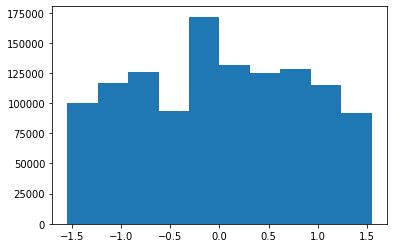

In [ ]:
plt.hist(bbdf["Normalized Evaluation"])
plt.show()

In [ ]:
# r1bqk2r/pp2ppbp/2np1np1/8/4P3/2N3P1/PPP1NPBP/R1BQK2R b KQkq - 4 8
def to_bitboard(fen):
    boards = np.zeros((29, 8, 8), dtype=np.uint8)
    board = chess.Board(fen)

    piece_to_layer = {
        'R': 1,
        'N': 2,
        'B': 3,
        'Q': 4,
        'K': 5,
        'P': 6,
        'p': 7,
        'k': 8,
        'q': 9,
        'b': 10,
        'n': 11,
        'r': 12
    }

    piece_to_material = {
        'R': 5,
        'N': 3,
        'B': 3,
        'Q': 9,
        'K': 0,
        'P': 1,
        'p': -1,
        'k': 0,
        'q': -9,
        'b': -3,
        'n': -3,
        'r': -5
    }

    color = bool(board.turn)

    cr = board.castling_rights
    wkcastle = bool(cr & chess.H1)
    wqcastle = bool(cr & chess.A1)
    bkcastle = bool(cr & chess.H8)
    bqcastle = bool(cr & chess.A8)

    boards[0, :, :]  = color
    boards[25, :, :] = wkcastle
    boards[26, :, :] = wqcastle
    boards[27, :, :] = bkcastle
    boards[28, :, :] = bqcastle

    material = 0

    piece_map = board.piece_map()
    for i, p in piece_map.items():
        rank, file = to_square(i)
        piece = p.symbol()
        # Mark the position of the piece on the bitboard
        boards[piece_to_layer[piece], rank, file] = 1
        material += piece_to_material[piece]
        # Attack maps
        for sq in board.attacks(i):
            attack_rank, attack_file = to_square(sq)
            boards[piece_to_layer[piece]+12, attack_rank, attack_file] = 1

    return boards

def to_square(number):
    rank, file = divmod(number, 8)
    return 7 - rank, file

In [ ]:
l = len(bbdf)
bbdf = bbdf.sample(frac=1)
train_df, test_df, cv_df = bbdf[:int(.8 * l)], bbdf[int(.8 * l): int(.9 * l)], bbdf[int(.9 * l):]

In [ ]:
import gc
gc.collect()

3703

In [ ]:
class ChessDataset(Dataset):
    def __init__(self, df):
        self.fens = torch.from_numpy(np.array([*map(to_bitboard, df["FEN"])], dtype=np.uint8))
        self.evals = torch.Tensor([[x] for x in df["Normalized Evaluation"]])
        self._len = len(self.evals)
        
    def __len__(self):
        return self._len
    
    def __getitem__(self, index):
        return self.fens[index], self.evals[index]

d_train, d_test, d_cv = map(ChessDataset, [train_df, test_df, cv_df])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Beeg model
# model = nn.Sequential(
#     nn.Conv2d(in_channels = 25, out_channels=200, kernel_size=5, padding=2),
#     nn.ReLU(),
#     nn.AvgPool2d(2, stride=(2, 2)),
#     nn.BatchNorm2d(200),
#     nn.Conv2d(200, 400, kernel_size=3, padding=1),
#     nn.Flatten(),
#     nn.Dropout(.1),
#     nn.Linear(6400, 100),
#     nn.Dropout(.6),
#     nn.Tanh(),
#     nn.Linear(100, 1)
# ).to(device)

# Architecture partially yoinked from geohotz
model = nn.Sequential(
    nn.Conv2d(29, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 128, kernel_size=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 128, kernel_size=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Dropout(.5),
    nn.Linear(256, 1)
).to(device)

def init_weights(m):
    try:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    except Exception:
        return

model.apply(init_weights)
    
# model(next(iter(cv_loader))[0].float())

Sequential(
  (0): Conv2d(29, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (7): ReLU()
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (16): ReLU()
  (17): BatchNorm2d(128, eps=1e-05, momentum=0.1, affin

In [ ]:
cv_loader = DataLoader(dataset=d_cv, batch_size=512, shuffle=False, num_workers=1)
train_loader = DataLoader(dataset=d_train, batch_size=512, shuffle=True, num_workers=1)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters())

In [ ]:
train_losses = []
cv_losses = []

for epoch in range(40):
    model.train()
    running_loss = []
    for data, target in train_loader:
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        y_pred = model(data.float())
        loss = criterion(y_pred, target)
        running_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    train_losses.append(sum(running_loss) / len(running_loss))
    print(f"[TRAIN] epoch: {epoch:5}, loss: {train_losses[-1]:10}", end="\t")
    
    with torch.no_grad():
        model.eval()
        running_loss = []
        for data, target in cv_loader:
            data, target = data.to(device), target.to(device)
            y_pred = model(data.float())
            loss = criterion(y_pred, target)
            running_loss.append(loss.item())
        cv_losses.append(sum(running_loss) / len(running_loss))
        print(f"[CV] epoch: {epoch:5}, loss: {cv_losses[-1]:10}")

[TRAIN] epoch:     0, loss: 0.4332221110343933	[CV] epoch:     0, loss: 0.3349039151313457
[TRAIN] epoch:     1, loss: 0.2932422960917155	[CV] epoch:     1, loss: 0.28890953647329454
[TRAIN] epoch:     2, loss: 0.2630676154534022	[CV] epoch:     2, loss: 0.2720313549041748
[TRAIN] epoch:     3, loss: 0.24266135017871857	[CV] epoch:     3, loss: 0.23631003765349692
[TRAIN] epoch:     4, loss: 0.22947569337685902	[CV] epoch:     4, loss: 0.22986757850393336
[TRAIN] epoch:     5, loss: 0.21808472034931184	[CV] epoch:     5, loss: 0.22543916448633722
[TRAIN] epoch:     6, loss: 0.20832966293493907	[CV] epoch:     6, loss: 0.23735631241443308
[TRAIN] epoch:     7, loss: 0.20045571571985882	[CV] epoch:     7, loss: 0.20514773764508837
[TRAIN] epoch:     8, loss: 0.19338013764222464	[CV] epoch:     8, loss: 0.20609389746442755
[TRAIN] epoch:     9, loss: 0.18705861132144927	[CV] epoch:     9, loss: 0.21106281584881723
[TRAIN] epoch:    10, loss: 0.18160117927392325	[CV] epoch:    10, loss: 0.

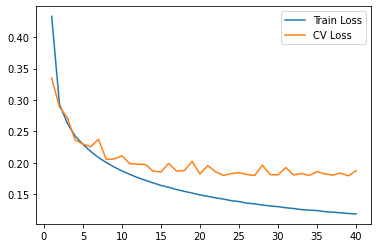

In [ ]:
train_losses = np.array(train_losses)
cv_losses = np.array(cv_losses)
epochs = np.array([*range(1, len(train_losses) + 1)])
plt.plot(epochs, train_losses)
plt.plot(epochs, cv_losses)
plt.legend(["Train Loss", "CV Loss"])
plt.show()